### Aahoka Data

In summary, we extracted basic information about 117 nomiees and 102 or organizations. 97 nominees has connections to at least one organizations, and 20 moniees has no connection to any organization.

A total number of 56 nominees have been contacted and more detailed data about themselves and their related organizations has been collected.

In this notebook, we parsed "ashoka-social-api-export.json" file, and extracted the tabular data about the nominees and organizations for further analysis.

The nominees data has been saved in "nominee_surveys.csv" file. And the organizations data has been saved in "orgs_surveys.csv" file 

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

ashoka_data_path = "data/ashoka-social-api-export (12).json"

Define funtions and load the data

In [2]:
def get_dict_value(dict_obj, key_value):
    return str(dict_obj[key_value]).replace("\t", "") if(key_value in dict_obj) else None

with open(ashoka_data_path) as data_file:    
    ashoka_data = json.load(data_file)

### Ashoka Nominees Data

In [3]:
nominees_array= []
nominees_data = ashoka_data["nominees"]
for key in nominees_data:
    nominee_dict = {}
    nominee_data = ashoka_data["nominees"][key]
    for key_ in nominee_data:
        nominee_dict[key_] = get_dict_value(nominee_data, key_)
    
    nominees_array.append(nominee_dict)
    
ashoka_nominees_df = pd.DataFrame(nominees_array)
ashoka_nominees_df.to_csv("nominees.csv", sep=';', encoding='utf-8')

In [4]:
ashoka_nominees_df.shape

(380, 17)

### Ashoka Organizations Data

In [5]:
orgs_array= []
orgs_data = ashoka_data["organizations"]
for key in orgs_data:
    org_dict = {}
    org_dict["org_id"] = key
    for key_ in orgs_data[key]:
        org_dict[key_] = get_dict_value(orgs_data[key], key_)
    
    orgs_array.append(org_dict)
    
ashoka_orgs_df = pd.DataFrame(orgs_array)
ashoka_orgs_df.to_csv("orgs.csv", sep=';', encoding='utf-8')

In [6]:
ashoka_orgs_df.shape

(362, 2)

### Nominees and orgs relationship

In [7]:
nominee_orgs_data = ashoka_data["nominee-organizations"]
len(nominee_orgs_data)

358

### Ashoka Surveys Data

In [8]:
index_keys = ["nomineeId", "education", "placeOfWork", "officeLocation", "orgs"]
file_name = "nominee_surveys.csv"
nominee_surveys_dict = []
orgs_surveys_dict = []
for key in ashoka_data["surveys"]:
    nominee_survey_dict = {}
    nominee_survey_dict["survey_id"] = key
    for key_lv2 in index_keys:
        nominee_survey_dict[key_lv2] = get_dict_value(ashoka_data["surveys"][key], key_lv2)
    
    nominee_survey_dict["typeOfImpact"] = []
    nominee_survey_dict["orgs_name"] = []
    nominee_survey_dict["numberImpacted"] = 0

    #validate that if the nominee belongs to any org.
    #if not, move on to next survey.
    nomineeId = ashoka_data["surveys"][key]["nomineeId"]
    if nomineeId not in nominee_orgs_data:
        continue
    
    #if yes, find out the survey info about the orgs.
    for org_key in nominee_orgs_data[nomineeId]:
        if org_key not in ashoka_data["surveys"][key]:
            continue
        
        org_survey_data = ashoka_data["surveys"][key][org_key]
        org_survey_dict = {}
        org_survey_dict["survey_id"] = key
        org_survey_dict["orgs_name"] = org_key

        for sub_key in org_survey_data:
            org_survey_dict[sub_key] = get_dict_value(org_survey_data, sub_key)
        orgs_surveys_dict.append(org_survey_dict)
        
        get_dict_value(org_survey_data, "numberImpacted")
        
        nominee_survey_dict["typeOfImpact"].append(get_dict_value(org_survey_data, "typeOfImpact"))
        nominee_survey_dict["numberImpacted"] += int(get_dict_value(org_survey_data, "numberImpacted") if get_dict_value(org_survey_data, "numberImpacted") is not None else 0)
#         nominee_survey_dict["founder"] = get_dict_value(org_survey_data, "founder")
        nominee_survey_dict["orgs_name"].append(org_key)
        
    nominee_surveys_dict.append(nominee_survey_dict)


nominee_surveys_df = pd.DataFrame(nominee_surveys_dict)
nominee_surveys_df = nominee_surveys_df.groupby('nomineeId', group_keys=True).apply(lambda x: x.apply(lambda values: next(el for el in values if el is not np.nan), axis="rows"))
# nominee_surveys_df.to_csv(file_name, sep=';', encoding='utf-8')
print(nominee_surveys_df.shape)

orgs_surveys_df = pd.DataFrame(orgs_surveys_dict)
orgs_surveys_df = orgs_surveys_df.groupby('orgs_name', group_keys=True).apply(lambda x: x.iloc[0])
orgs_surveys_df.shape

(331, 9)


(326, 33)

### Merge survey data for nominees

In [9]:
merged_nominees_df = pd.merge(ashoka_nominees_df, nominee_surveys_df, 
                               how="left", left_on = 'id', right_on = 'nomineeId')
merged_nominees_df.to_csv("nominees_suryves.csv", sep=';', encoding='utf-8')
merged_nominees_df.shape

(380, 26)

### Merge survey data for orgs

In [10]:
merged_orgs_df = pd.merge(ashoka_orgs_df, orgs_surveys_df, 
                               how="left", left_on = 'name', right_on = 'orgs_name')
merged_orgs_df.to_csv("orgs_suryves.csv", sep=';', encoding='utf-8')
merged_orgs_df.shape
# orgs_surveys_df

(362, 35)

## Analysis Examples

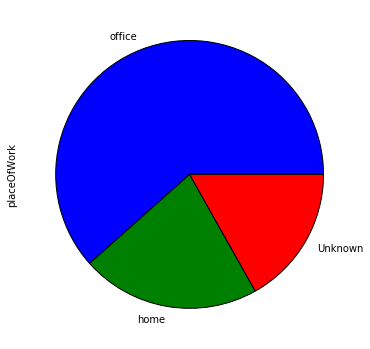

In [11]:
merged_nominees_df["placeOfWork"].fillna("Unknown", inplace=True)
placeOfWork = merged_nominees_df["placeOfWork"]
placeOfWork.value_counts().plot.pie(figsize=(6, 6))

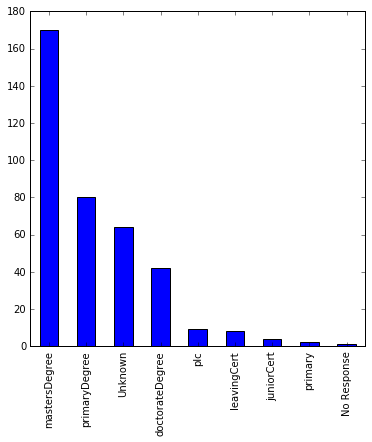

In [12]:
merged_nominees_df["education"].fillna("Unknown", inplace=True)
education = merged_nominees_df["education"]
education.value_counts().plot.bar(figsize=(6, 6))

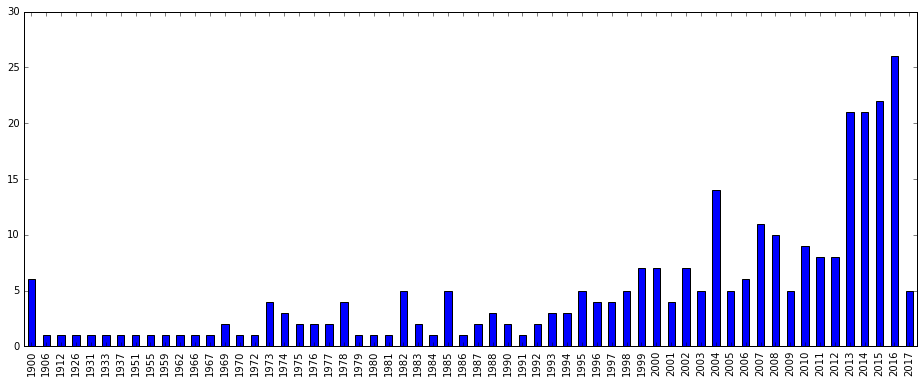

In [13]:
orgs_year = merged_orgs_df["year"]
orgs_year.value_counts().sort_index().plot.bar(figsize=(16, 6))

# Impact Analysis

In [14]:
merged_orgs_df.columns

Index(['name', 'org_id', 'Comments', 'additionalNotes', 'barrierOrgImpact',
       'barrierYourImpact', 'duties', 'founder', 'fullTimeEmployeeNumber',
       'fundingSources', 'fundingSources-Comment', 'fundingSourcesMain',
       'fundingSourcesMain-Comment', 'mostValuableProBono', 'numberImpacted',
       'organisationSector', 'orgs_name', 'partTimeEmployeeNumber', 'probono',
       'question5', 'reasonForFieldOfWork', 'registeredEntity',
       'registeredType', 'registeredType-Comment', 'sectors', 'survey_id',
       'title', 'typeOfImpact', 'typeOfImpact-Comment', 'updates',
       'volunteerNumber', 'what', 'whyJoinFounder', 'whyNotFounder', 'year'],
      dtype='object')

In [15]:
def pie_chart_for_impact(orgs_df, public_funded_org, funds_resouces_name):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True, figsize=(20,20))    

    impact_counts_per_type=orgs_df[['name', 'typeOfImpact']][orgs_df['typeOfImpact'].notnull()].groupby(['typeOfImpact']).agg(['count'])
    labels_per_type = impact_counts_per_type['name']['count'].keys().tolist()
    sizes_per_type = impact_counts_per_type['name']['count'].values
    explode = (0, 0.1, 0)
    ax1.pie(sizes_per_type, explode=explode, labels=labels_per_type, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.title.set_text("Impact type distribution for all funded orgs")
    
    impact_counts_per_type=public_funded_org[['name', 'typeOfImpact']][public_funded_org['typeOfImpact'].notnull()].groupby(['typeOfImpact']).agg(['count'])
    labels_per_type = impact_counts_per_type['name']['count'].keys().tolist()
    sizes_per_type = impact_counts_per_type['name']['count'].values
    explode = (0, 0.1, 0)
    ax2.pie(sizes_per_type, explode=explode, labels=labels_per_type, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.title.set_text("Impact type distribution for {} orgs".format(funds_resouces_name))
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


    impact_counts_per_entity=orgs_df[['name', 'registeredType']][orgs_df['registeredType'].notnull()].groupby(['registeredType']).agg(['count'])
    labels_per_entity = impact_counts_per_entity['name']['count'].keys().tolist()
    sizes_per_entity = impact_counts_per_entity['name']['count'].values
    explode_per_entity = (0, 0.1, 0, 0.0)
    ax3.pie(sizes_per_entity, explode=explode_per_entity, labels=labels_per_entity, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax3.title.set_text("Org entity distribution for all funded")
    ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    impact_counts_per_entity=public_funded_org[['name', 'registeredType']][public_funded_org['registeredType'].notnull()].groupby(['registeredType']).agg(['count'])
    labels_per_entity = impact_counts_per_entity['name']['count'].keys().tolist()
    sizes_per_entity = impact_counts_per_entity['name']['count'].values
    explode_per_entity = (0, 0.1, 0, 0.0)
    ax4.pie(sizes_per_entity, explode=explode_per_entity, labels=labels_per_entity, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax4.title.set_text("Org entity distribution from {}".format(funds_resouces_name))
    ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    impact_counts_per_entity=orgs_df[['name', 'organisationSector']][orgs_df['organisationSector'].notnull()].groupby(['organisationSector']).agg(['count'])
    labels_per_entity = impact_counts_per_entity['name']['count'].keys().tolist()
    sizes_per_entity = impact_counts_per_entity['name']['count'].values
    explode_per_entity = (0, 0.1, 0, 0, 0.0)
    ax5.pie(sizes_per_entity, explode=explode_per_entity, labels=labels_per_entity, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax5.title.set_text("Impact sector distribution for all funded")
    ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    impact_counts_per_entity=public_funded_org[['name', 'organisationSector']][public_funded_org['organisationSector'].notnull()].groupby(['organisationSector']).agg(['count'])
    labels_per_entity = impact_counts_per_entity['name']['count'].keys().tolist()
    sizes_per_entity = impact_counts_per_entity['name']['count'].values
    explode_per_entity = (0, 0.1, 0, 0, 0.0)
    ax6.pie(sizes_per_entity, explode=explode_per_entity, labels=labels_per_entity, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax6.title.set_text("Impact sector distribution from {}".format(funds_resouces_name))
    ax6.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=3.0)
    plt.show()

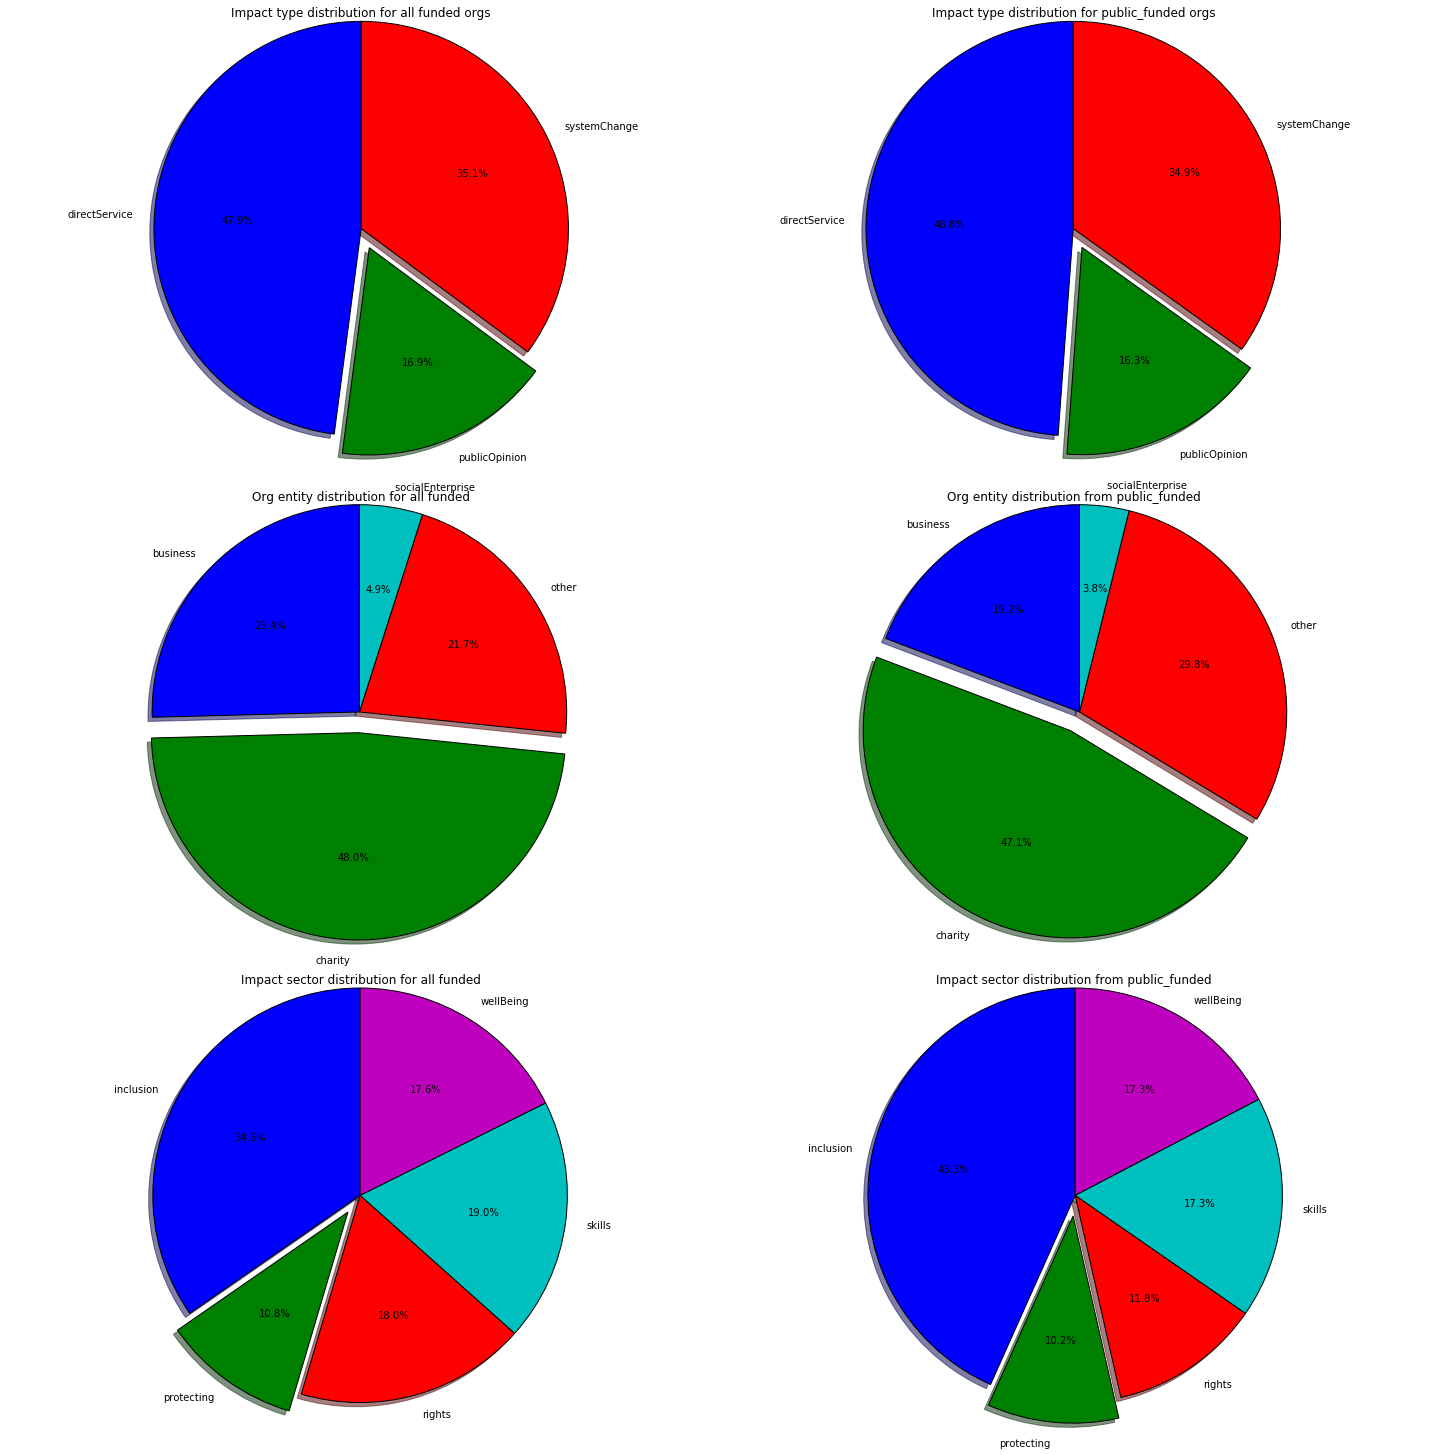

In [16]:
public_funded_org = merged_orgs_df.loc[merged_orgs_df['fundingSourcesMain'] == 'public']
pie_chart_for_impact(merged_orgs_df, public_funded_org, "public_funded")

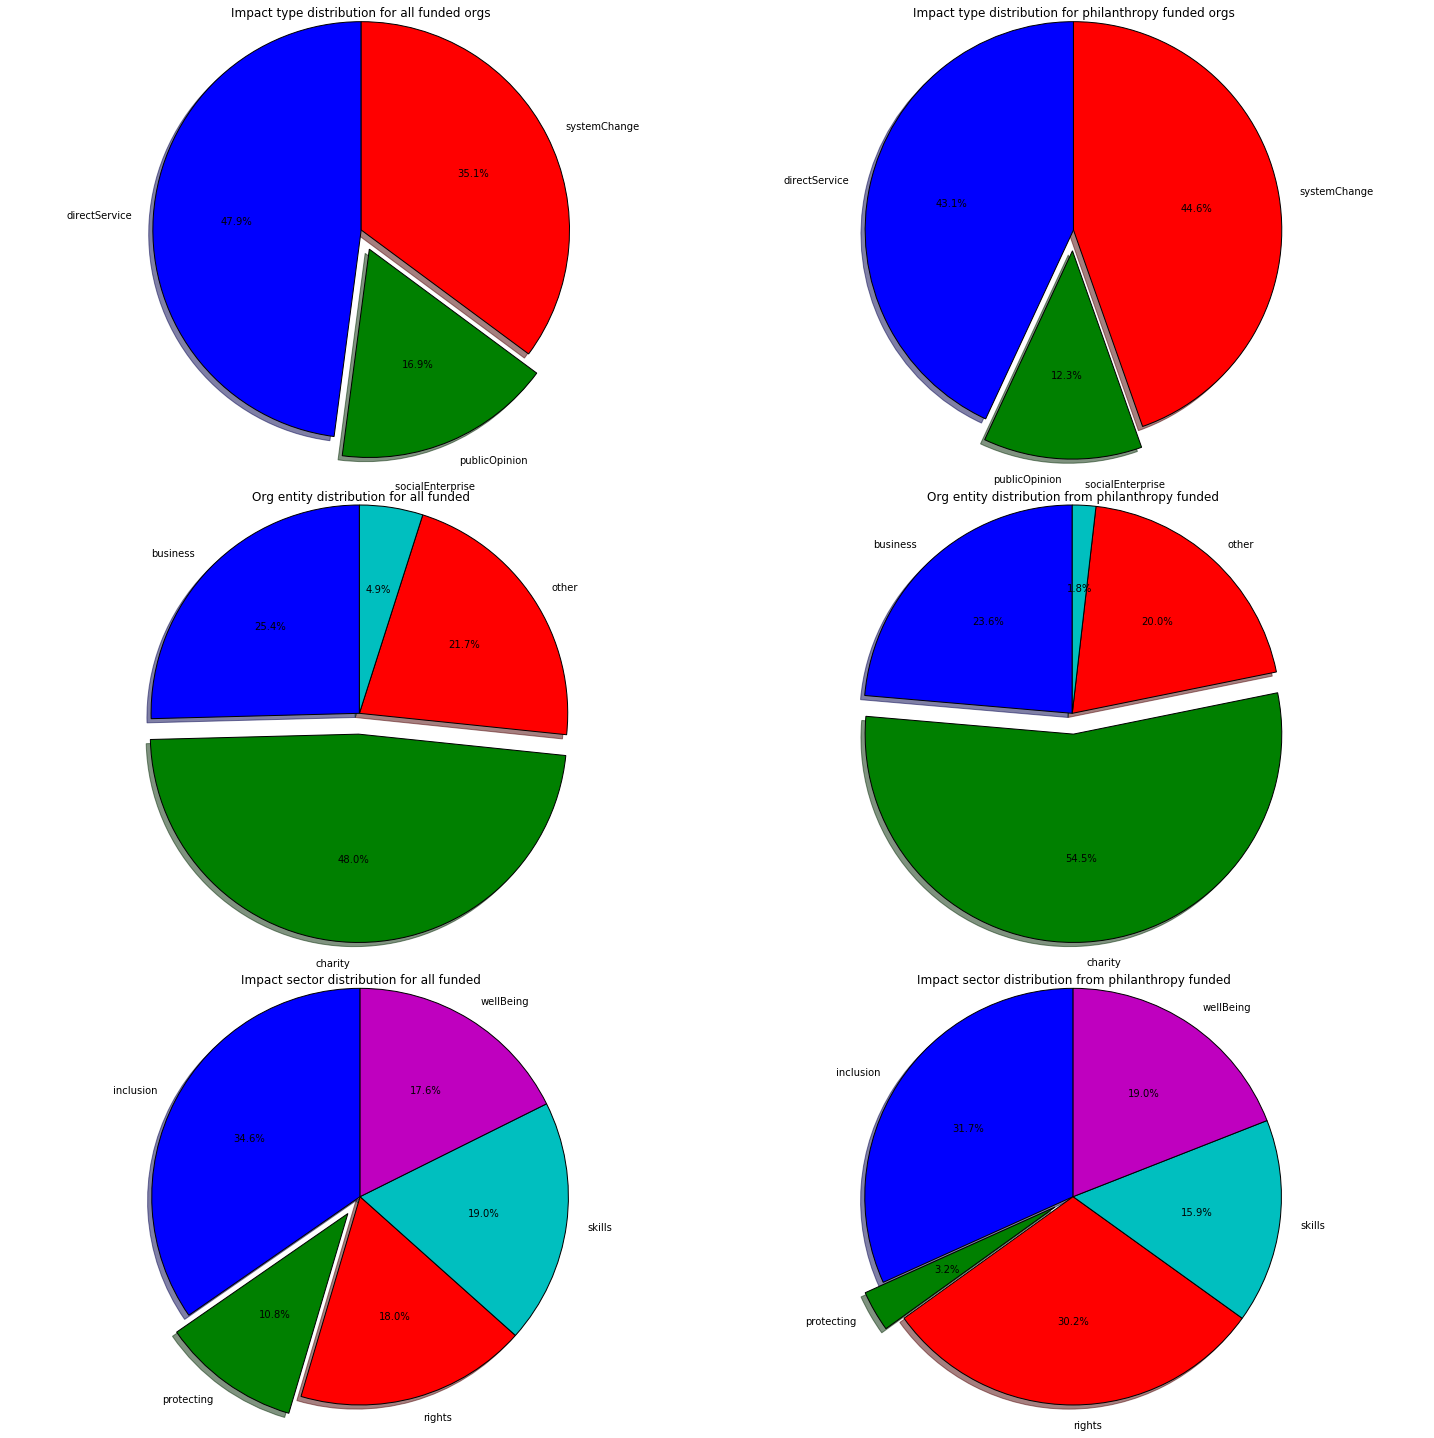

In [17]:
philanthropy_funded_org = merged_orgs_df.loc[merged_orgs_df['fundingSourcesMain'] == 'philanthropy']
pie_chart_for_impact(merged_orgs_df, philanthropy_funded_org, "philanthropy funded")

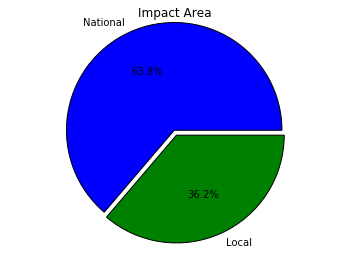

In [19]:
# Localised vs. Ireland-wide impact for each org:
merged_orgs_df["question5"].str.contains("National").value_counts()
plt.pie([197, 112], explode=(0.05, 0), labels =["National", "Local"],  autopct='%1.1f%%')
plt.title("Impact Area")
plt.axis('equal') 
plt.show()